<a href="https://colab.research.google.com/github/osvlandi/AI_for_medicine/blob/main/diagnosis/week1-disease-detection/Image_preprocessing_for_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Image Preprocessing for AI Model Training


## 📘 1. Introduction

In this notebook, we’ll practice key **preprocessing techniques** for preparing medical imaging datasets to train deep learning models.

We’ll use techniques such as:

- **One-hot encoding** of multi-label findings  
- **Data augmentation** to improve model generalization  
- **Image standardization** for consistent input formatting

We'll also perform **exploratory data analysis** using data visualization techniques and image inspection to better understand the dataset's structure and content.

The dataset used is [ChestX-ray8](https://arxiv.org/abs/1705.02315), a publicly available collection of chest X-ray images widely used in research on **automated disease detection**.


---


### 🛠️ 1.1 Setup and Visualization

To get started, we set up the environment and visualize some sample medical images to better understand the dataset.

**Steps:**

- **Mount Google Drive** to access any necessary files (e.g., images or datasets).
- **Import essential Python libraries**, including:
  - Data manipulation: `pandas`, `numpy`
  - Data visualization: `matplotlib`, `seaborn`
  - File system access: `os`

---

This setup ensures the environment is ready for exploration, visualization, and later, modeling of medical imaging data.

In [1]:
# Mount Google Drive to access your personal files within the Colab environment
# If you are not using Google Colab then you don't need it.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Import essential libraries for data manipulation, numerical computing, visualization, and file handling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tarfile
import random
import os
import seaborn as sns

sns.set()  # Set seaborn’s default style for cleaner and more readable plots


### 🩻 Chest X-ray Examples

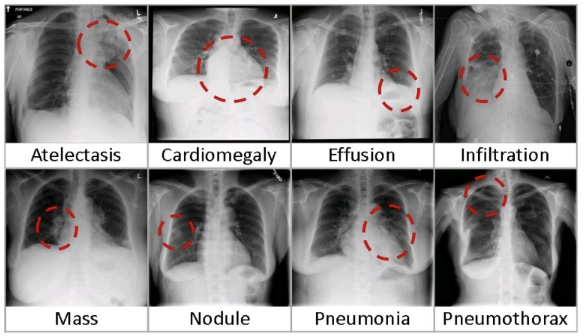

In [3]:
# Examples from the ChestX-ray8 article
from IPython.display import Image, display, Markdown

display(Markdown("### 🩻 Chest X-ray Examples"))
display(Image(filename="/content/drive/MyDrive/Colab Notebooks/Imagem.jpg"))

### 🗂️ 1.2 Loading the Annotation Data

Medical imaging datasets used for AI typically include one or more **annotation files**, usually in `.csv` or similar formats.

These files contain important **metadata**, such as:

- Image-level labels  
- Diagnostic findings  
- Patient demographics

This information is essential for **supervised learning** tasks, as it provides the **ground truth** needed to train and evaluate models.

Additionally, annotations often include context that helps with:

- Data filtering  
- Stratification  
- Analysis


In [4]:
# Loading and visualizing the annotations file
annotations = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/image_index.csv')
annotations.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


###🔍 1.3 Understanding the Annotations File

The `image_index.csv` file contains metadata associated with each medical image in the dataset.  
This metadata is essential for preprocessing, training, and evaluating AI models.

---

### Column Descriptions

- **Image Index**: Filename of the corresponding X-ray image.

- **Finding Labels**: Diagnoses or findings observed in the image.  
  Multiple findings are separated by `|`.  
  If no pathology is found, the label is `"No Finding"`.

- **Follow-up #**: Indicates the exam sequence for a patient  
  (e.g., `0` for the first exam, `1` for a follow-up).

- **Patient ID**: Unique identifier for each patient.  
  Useful for grouping images and avoiding data leakage *(more on that later)*.

- **Patient Age**: Age of the patient at the time of the exam.

- **Patient Sex**: Sex of the patient (`M` for male, `F` for female).

- **View Position**: Position in which the X-ray was taken (e.g., `PA` for posteroanterior).

- **OriginalImage[Width] / [Height]**: Original resolution of the image in pixels.

- **OriginalImagePixelSpacing[x] / [y]**: Physical spacing between pixels (in millimeters).  
  This helps ensure accurate measurements and consistent image standardization.

---

> This metadata plays a critical role in structuring the data for reliable model training and evaluation.


## 🧹 2. Data Wrangling for Medicine AI

> In this part of the notebook, we'll focus on **data wrangling** — the process of cleaning, transforming, and organizing raw medical data into a structured and usable format.

---

### Why It’s Important

Medical data usually comes from a mix of sources, such as:

- Electronic Health Records (EHRs)
- Lab results
- Medical imaging (e.g., X-rays)

Because of that, it's often:

- Messy  
- Incomplete  
- Inconsistent

---

### What We'll Achieve

By wrangling this data, we will:

- **Improve Data Quality:** Ensure accuracy, consistency, and completeness — all crucial for model performance.
- **Enable Integration:** Combine and align data across different modalities.
- **Prepare for Modeling:** Convert the data into the format needed to train a **Convolutional Neural Network (CNN)**.

---

**By the end of this section**, we'll have a clean, well-structured dataset — ready for CNN-based training.


In [5]:
# Inspecting the structure of the dataset and check for missing values or incorrect data types.
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Sex                  112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


## 2.1 🔢 One-hot Encoding of Medical Findings

In the original dataset, the `Finding Labels` column can contain **one or more diagnoses per image**, stored as a single string separated by the `|` character. For example: `"Cardiomegaly|Emphysema"`.

⚠️ This format is **not directly usable** for training machine learning models, especially in **multi-label classification** tasks.

---

### What Should We Do

To make this data usable for modeling, we **convert** the `Finding Labels` column into multiple **binary columns**, one for each possible medical condition.

Each new column indicates whether a specific finding is present (`1`) or not (`0`) in the image. This transformation is known as **multi-label one-hot encoding**.

---

### Why This Matters

This format allows us to:

- **Train models** that can predict multiple findings at once
- **Compute class-wise performance metrics** (e.g., precision, recall, AUC)
- Ensure the labels are structured for loss functions like **binary cross-entropy**, commonly used in multi-label classification.

In [6]:
# Selecting the part of the dataset that we will use for model training
train_df = annotations.loc[:, 'Image Index':'Patient ID'].copy()
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID
0,00000001_000.png,Cardiomegaly,0,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1
2,00000001_002.png,Cardiomegaly|Effusion,2,1
3,00000002_000.png,No Finding,0,2
4,00000003_001.png,Hernia,0,3
...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801
112116,00030802_000.png,No Finding,0,30802
112117,00030803_000.png,No Finding,0,30803
112118,00030804_000.png,No Finding,0,30804


In [7]:
# Replace 'No Finding' with an empty string (optional)
train_df['Finding Labels'] = train_df['Finding Labels'].replace('No Finding', '')

# Perform one-hot encoding on the 'Finding Labels' column
findings_encoded = train_df['Finding Labels'].str.get_dummies(sep='|')

findings_encoded.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
# Concatenate the one-hot columns with the original image and patient info
train_df_one_hot = pd.concat([train_df[['Image Index', 'Patient ID']], findings_encoded], axis=1)

# Display the result
train_df_one_hot.head()

,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_001.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### 2.2 📊 Label Distribution Analysis

Before training our model, it is essential to explore the **distribution of cases across the different labels** in the dataset.  
This step helps us understand how frequent (or rare) each medical condition is.

#### Why This Matters

- **Class imbalance awareness**: Medical datasets often contain highly imbalanced classes (e.g., some conditions are very rare compared to others). Knowing this helps us choose appropriate strategies such as class weighting, oversampling, or data augmentation.

- **Better evaluation metrics**: If the dataset is imbalanced, accuracy alone can be misleading.  
  Understanding label distribution guides us toward more informative metrics like precision, recall, F1-score, and AUC.

- **Model training guidance**: Some diseases may require more careful handling in training to ensure the model does not simply ignore minority classes.

---

By analyzing the **label distribution**, we set the foundation for a more reliable and fair evaluation of our model’s performance.


In [9]:
# Select only the disease columns (ignore Image Index and Patient ID)
label_counts = train_df_one_hot.drop(columns=['Image Index', 'Patient ID']).sum().sort_values(ascending=False)

# Display the counts
print(label_counts)

Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64


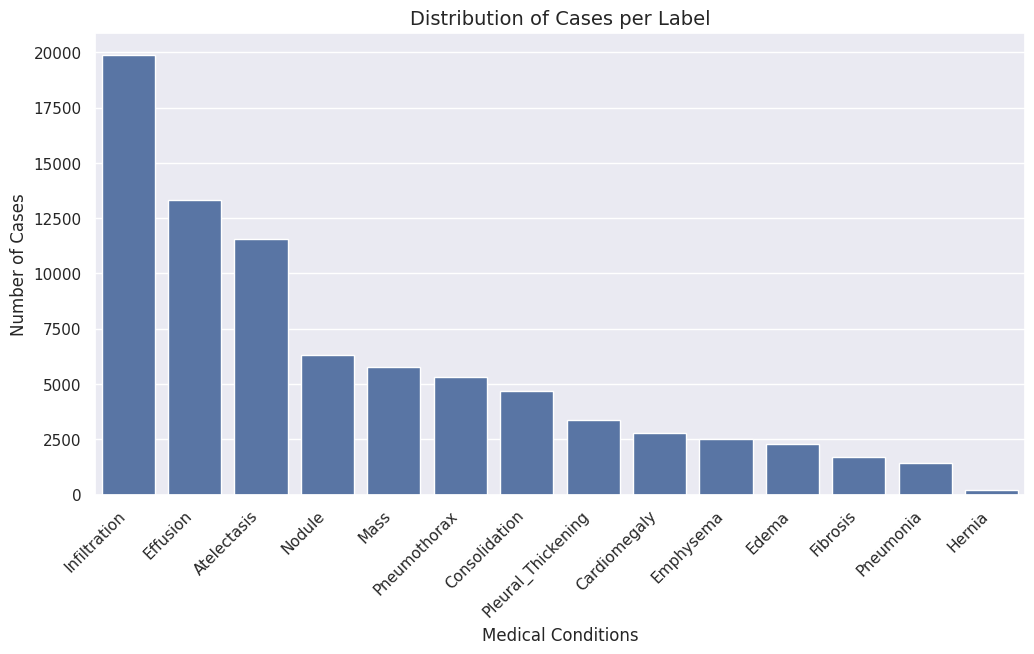

In [10]:
# Plot the label distribution
plt.figure(figsize=(12,6))
sns.barplot(x=label_counts.index, y=label_counts.values)

plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Cases per Label", fontsize=14)
plt.ylabel("Number of Cases")
plt.xlabel("Medical Conditions")
plt.show()

The distribution shows that some conditions, such as **Infiltration**, **Effusion**, and **Atelectasis**, occur much more frequently in the dataset compared to others like **Fibrosis**, **Pneumonia**, or **Hernia**.

This imbalance reflects real-world clinical settings, where certain findings are naturally more common in chest X-rays.  
For example:
- **Infiltration and Effusion** are frequently observed in patients with infections or chronic diseases.  
- **Rare findings** (e.g., Hernia, Fibrosis) appear in far fewer cases, making them harder to detect and classify with machine learning models.

> 👉 This highlights the need for strategies to handle **class imbalance**, so the model does not become biased toward the most frequent conditions (more on that later).

## 3. Working with Tarball Files in Medical Imaging

The tarball format `(.tar.gz)` is commonly used to bundle and compress multiple files into a single archive, combining `tar` (for packaging) and `gzip` (for compression). In medical imaging, it's widely used to store and distribute large datasets of medical scans (e.g., X-rays, CTs) efficiently and in an organized structure.

Below, we will define the path to a `.tar.gz file` containing medical images and specify the folder where the files will be extracted. Using Python's tarfile module, we open and extract its content. This is a key step before performing image processing, analysis, or training machine learning models.

In [11]:
# Sets the path to the zipped image file
tar_path = "/content/drive/MyDrive/Colab Notebooks/images_001.tar.gz"

# Sets the path where all files will be extracted
extract_path = "/content/drive/MyDrive/Colab Notebooks"

# Extracts all images from the selected zip file
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

### 3.1 🔍 Inspecting Medical Images with Matplotlib

After extracting the images from the tarball file, we can use `Matplotlib` to visually inspect the dataset.

We begin by setting the path to the folder where the images were extracted. Next, we generate a list of all image file paths in that directory. From this list, we randomly select a few images using `random.sample`.

Each image is loaded with `mpimg.imread()` and displayed in grayscale using `cmap='gray'` to preserve the typical appearance of medical scans, such as X-rays.

This quick visual check helps ensure that the images were extracted correctly and gives us a better understanding of the dataset before moving into further analysis or modeling.

> 🎯 *Run the code below to randomly select and display 3 new cases.*

Number of images extracted: 4999


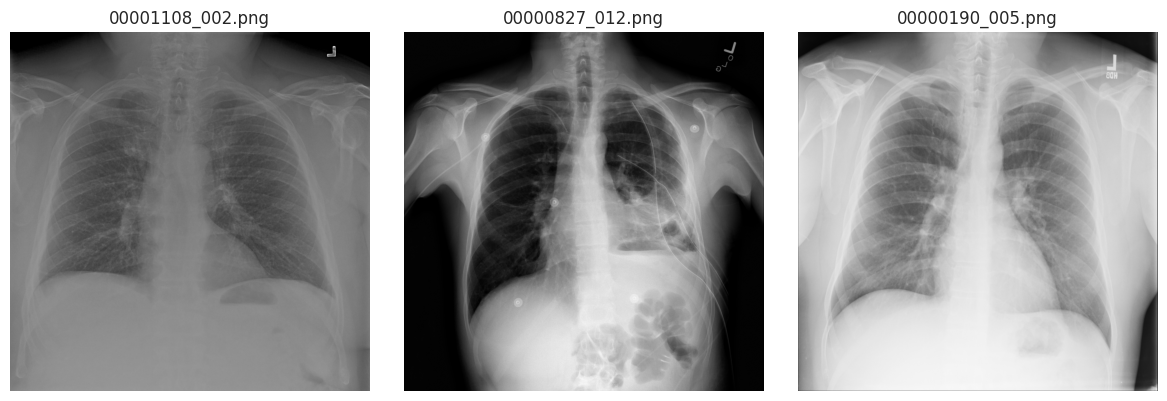

In [14]:
# Updates the path to the extracted files
extract_path = "/content/drive/MyDrive/Colab Notebooks/images"

# Concatenates the file name to their paths and saves in a list
image_paths = [os.path.join(extract_path, f) for f in os.listdir(extract_path)]
print(f"Number of images extracted: {len(image_paths)}")

# Samples 3 random image file names from the list
random_images = random.sample(image_paths, 3)

# Displays the selected images
plt.figure(figsize=(12, 4))  # Adjusts figure size

for i, path in enumerate(random_images):
    img = mpimg.imread(path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(os.path.basename(path))

plt.tight_layout()
plt.show()

### 📌 3.2 Taking a Closer Look at a Medical Image

In this step, we focus on a single chest X-ray image to explore it in more detail.

We start by selecting one image from our dataset and loading it with `mpimg.imread()`. This gives us direct access to the pixel intensity values, which are represented as numerical arrays.

In [36]:
sample_img = image_paths[0]
print(sample_img)

/content/drive/MyDrive/Colab Notebooks/images/00000116_028.png


In [38]:
raw_image = mpimg.imread(sample_img)
print(raw_image)

[[0.07058824 0.11372549 0.10196079 ... 0.07843138 0.08235294 0.05098039]
 [0.13725491 0.22745098 0.20784314 ... 0.16078432 0.17254902 0.10196079]
 [0.12941177 0.21176471 0.19607843 ... 0.15686275 0.16470589 0.09411765]
 ...
 [0.3137255  0.54509807 0.52156866 ... 0.35686275 0.3647059  0.20392157]
 [0.31764707 0.5568628  0.5254902  ... 0.3647059  0.36862746 0.20784314]
 [0.15294118 0.26666668 0.24705882 ... 0.17254902 0.1764706  0.10196079]]


We then visualize the image using Matplotlib with a grayscale colormap `(cmap='gray')` to preserve the standard look of medical scans. Along with the visualization, we also compute some basic statistics:



*   Width and Height (image resolution in pixels)
*   Maximum and Minimum pixel values (range of intensity)
*   Average pixel value (brightness level)
*   Standard deviation (contrast and variability in intensity)










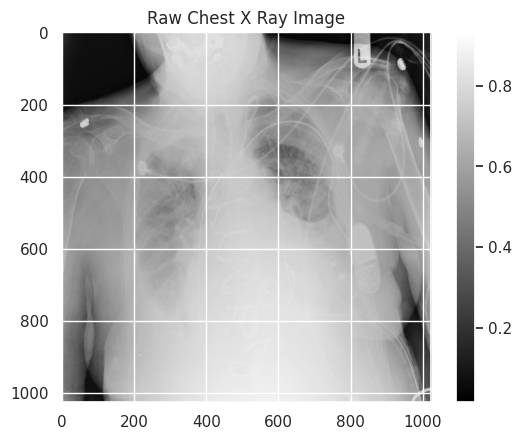


Image Width: 1024 px
Image Height: 1024 px
Max pixel value: 0.9333
Min pixel value: 0.0157
Average pixel value: 0.6037
Standard deviation: 0.1972


In [61]:
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
plt.show()

print("")
print(f"Image Width: {raw_image.shape[0]} px")
print(f"Image Height: {raw_image.shape[1]} px")
print(f"Max pixel value: {raw_image.max():.4f}")
print(f"Min pixel value: {raw_image.min():.4f}")
print(f"Average pixel value: {raw_image.mean():.4f}")
print(f"Standard deviation: {raw_image.std():.4f}")

Text(-11.430555555555548, 0.5, '# Pixels in Image')

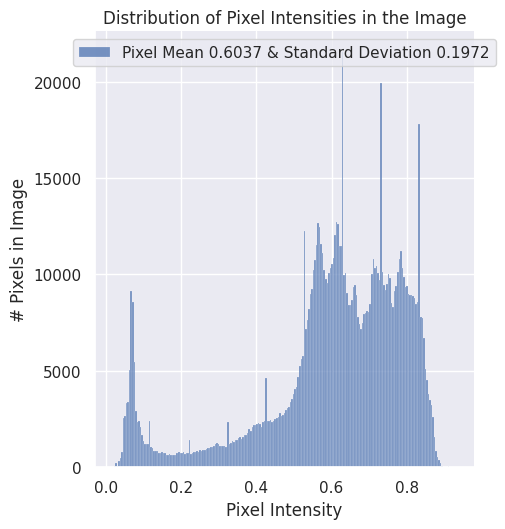

In [64]:
# Plot a histogram of the distribution of the pixels
sns.displot(raw_image.ravel(),
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

> ⚠️ Analyzing these properties is important because it helps us verify the quality and consistency of the data before applying any preprocessing or training machine learning models. It ensures that the images are correctly loaded, normalized, and ready for further steps in the pipeline.